In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple
from dataclasses import dataclass
from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from PIL import Image
from IPython import display

In [2]:
# Parametri okruzenja
MASTER_FOLDER = 'cyclegan' # Folder gde se cuvaju svi rezultati
BATCH_SIZE = 40 
IMG_SIZE = 32 # Pozeljno je da dimenzija slike bude stepen dvojke zbog U-NET modela
IMG_CHANNELS = 1
SKUP_PODATAKA = 'mnist' # 'fashion_mnist'

In [27]:
from library.mnist import prepare_mnist_dataset
tf_train, tf_test = prepare_mnist_dataset('mnist')

In [28]:
tf_train_contrast = tf_train.map(lambda _, x: (x, 1-x))
tf_test_contrast = tf_test.map(lambda _, x: (x, 1-x))

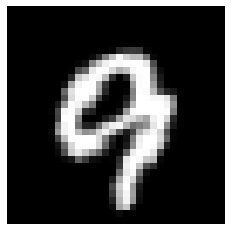

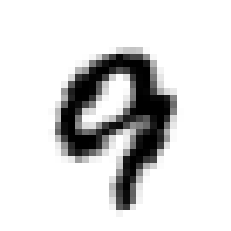

In [29]:
from library.visualization import show_image
for x, y in tf_train_contrast.take(1):
    show_image(x[5])
    show_image(y[5])

In [39]:
from library.unet_generator import UNetGeneratorBuilder

def create_generator(*args, **kwargs):
    generator_builder = UNetGeneratorBuilder(*args, **kwargs)
    generator_builder.add_downsample_layer(16, 3, apply_batchnorm=True)
    generator_builder.add_downsample_layer(32, 3)
    generator_builder.add_upsample_layer(16, 3, apply_dropout=True)
    return generator_builder.build()

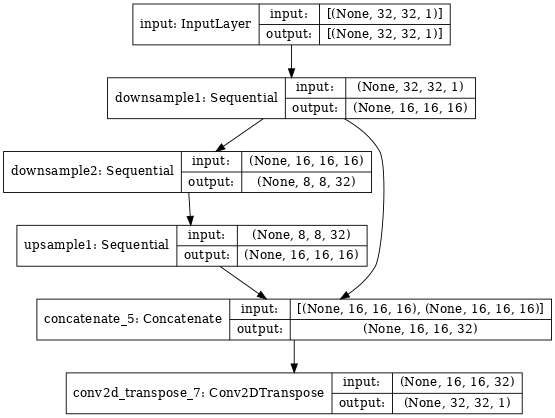

In [40]:
generator_g = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
generator_f = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

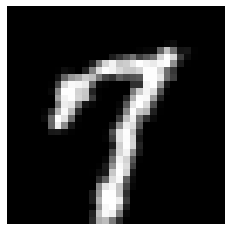

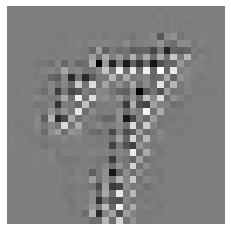

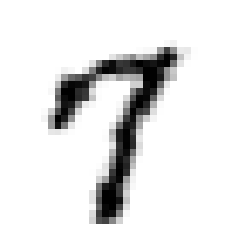

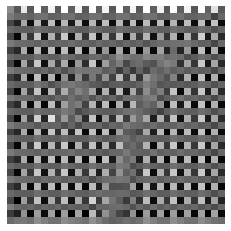

In [44]:
for x, y in tf_train_contrast.take(1):
    show_image(x[3])
    show_image(generator_g(x)[3])
    show_image(y[3])
    show_image(generator_f(y)[3])

In [34]:
from library.unet_generator import downsample

def create_discriminator(input_size: int):
    """
    Diskriminator se sastoji iz niza "downsample" slojeva.
    Napomena: Diskriminator ocenjuje nekoliko ravnomerno rasporedjenih kvadrata na slici
    i za svaki govori da li je slika prava ili ne. 

    :param input_size: Dimenzija ulazne slike
    :return: Diskriminator
    """
    inputs = layers.Input(shape=[input_size, input_size, 1], name='disc_input')
    target = layers.Input(shape=[input_size, input_size, 1], name='disc_target')

    x = layers.concatenate([inputs, target])

    x = downsample(16, 4, apply_batchnorm=False)(x)
    x = downsample(32, 4)(x)
    x = layers.Conv2D(1, 5, strides=1)(x)
    x = layers.Conv2D(1, 4, strides=1)(x)

    return keras.Model(inputs=[inputs, target], outputs=x)

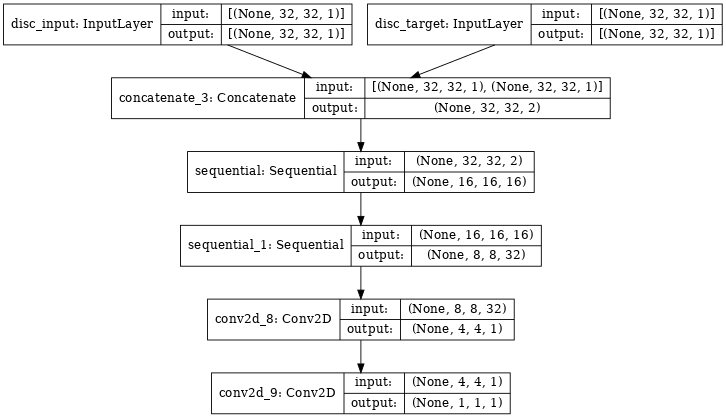

In [49]:
discriminator_x = create_discriminator(input_size=IMG_SIZE)
discriminator_y = create_discriminator(input_size=IMG_SIZE)
keras.utils.plot_model(discriminator_g, show_shapes=True, dpi=64)

In [47]:
# Podesavanje optimizatora
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [45]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

disc_alpha = 0.5
cycle_alpha = 10

def discriminator_loss(real_images, generated_images):
    real_loss = bce(tf.ones_like(real_image), real_image)
    gen_loss = bce(tf.zeros_like(generated_image), generated_imge)
    return (real_loss + gen_loss) * disc_alpha
    
def generator_loss(generated_images):
    return bce(tf.ones_like(generated_images), generated_images)

def cycle_loss(real_images, cycled_images):
    return tf.reduce_mean(tf.abs(real_images - cycled_images)) * cycle_alpha

def identity_loss(real_images, generated_image_of_same_type):
    return tf.reduce_mean(tf.abs(real_image - generated_image_of_same_type)) * cycle_alpha * 0.5

In [51]:
# Podesavanje logovanja
summary_writer = tf.summary.create_file_writer(f'{MASTER_FOLDER}/logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [50]:
# Podesavanje parametara za periodicnog cuvanja stanja modela
checkpoint_path = f'{MASTER_FOLDER}/checkpoints/train'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')